In [1]:
#import stuff
import pandas as p
import numpy as n
import seaborn as s
from matplotlib import pyplot as plt
import lib as l

In [2]:
#import data
pokemon = p.read_csv('data/pokemon.csv', header = None, 
                     skiprows=1, encoding = 'latin-1', low_memory = False,
                    names = ['Name', 'Version', 'Primary Type' ,'Secondary Type', 'Stage' ,'Attack', 'Defense' , 'HP', 'Sp. Attack', 'Sp. Defense', 'Speed', 'Total']
)
noMega = pokemon[pokemon['Version'].isnull()] # for KNN alg

img = plt.imread("logo.png") # get the pokemon logo :)

# Question 1;

This is the data set of all current pokemon as of 11/23/21. This represents a statistical outlook of the 1045 pokemon. This includes legendaries, mythical, and mega evolution variants. Their attributes are broken down into 7 numerical categories. They represents how strong the corresponding attribute of the pokemon is. So the higher the value, the stronger the attribute will be. The categories are as follows:

    - HP
    - Attack
    - Defense
    - Special Attack
    - Special Defense
    - Speed
    - Total
    
These are not the actual values of the attributes. _i.e._ If I have a Lvl 100 Venusaur, I won't have 82 Attack. It is more like a scale that determines the boundaries that a pokemon's attributes are tied to. 

# Question 2;

There are few, not so obvious **classes** that are present in this data set. One of which can be determining if a pokemon is considered _Statistically Strong_. This has a vague definition, but generally the higher the pokemon's attributes are, the better they can do in battle. For our purpose, we will define statistically strong as _having a higher total than 500, as well as having at least 3 of their 6 attributes being in the third quartile of all values._ This will hopefully eliminate any outliers or pokemon that have all their power in a few stats. **(Blissey)**

Another class is whether the pokemon have a secondary type or not. There really is no correlation with the data we currently have, but if we added a column that gave us the evolution stage that a pokemon is in, (1, 2, or 3), we could define secondary types with evolution stage as a potential class. 

## Important Statistics & Info of the Set:

1. We will be excluding ALL mega evolution forms of pokemon as well as **Eternamax** for our KNN alg because they will cause some annoying skewing.

2. For our K-means clustering algorithm, we will be including all 1045 pokemon. This will prove our point later on that K-means is NOT a good algorithm to use on this data set.

We will provide some basic stats about our set below:

In [3]:
stats = noMega.describe().round(3)
stats

,Stage,Attack,Defense,HP,Sp. Attack,Sp. Defense,Speed,Total
count,870.000,870.000,870.000,870.000,870.000,870.000,870.000,870.000
mean,1.614,76.017,71.511,68.706,69.117,69.387,65.143,419.882
std,0.704,29.471,29.533,26.272,29.061,26.859,28.110,110.641
min,1.000,5.000,5.000,1.000,10.000,20.000,5.000,180.000
25%,1.000,55.000,50.000,50.000,45.000,50.000,45.000,320.000
50%,1.000,75.000,67.000,65.000,65.000,65.000,64.000,430.000
75%,2.000,95.000,90.000,80.000,90.000,85.000,85.000,500.000
max,3.000,181.000,230.000,255.000,173.000,230.000,200.000,720.000


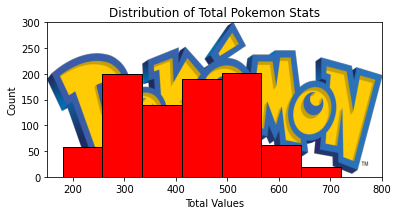

In [4]:
#distribution of total values (no mega or eternamax)
noMega['Total'].hist(color = 'red', ec = 'black', grid = False, bins = 7)
plt.title("Distribution of Total Pokemon Stats")
plt.xlabel("Total Values")
plt.ylabel("Count")
plt.imshow(img, extent = [150, 800, 0, 300])

# K-nearest Neighbors Algorithm

In [8]:
#Pokemon data using HP and Total 
# Total > 599
# HP > 79.99

knn = l.KNN(3)

knn_set = noMega[['HP', 'Total']].to_numpy()
labels = noMega['Stage'].values 

knn.train(knn_set, labels)

random_pokemon = [255,480]
pred = knn.predict(random_pokemon)

print(f'The predicted stage of {random_pokemon} is ~> Stage {pred.most_common(1)[0][0]}')

The predicted stage of [255, 480] is ~> Stage 2


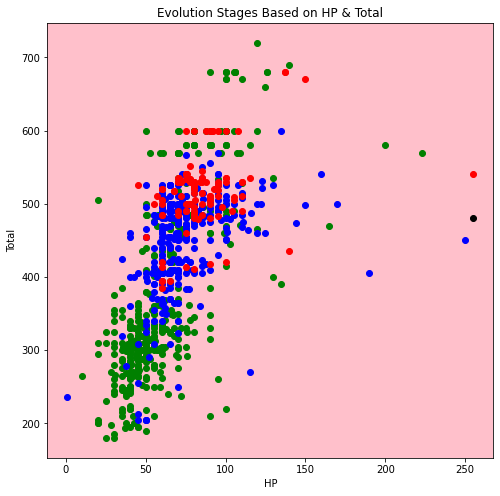

In [11]:
# SPLIT INTO OUR THREE STAGES 
stage_one = noMega[noMega['Stage'] == 1]
stage_two = noMega[noMega['Stage'] == 2]
stage_three = noMega[noMega['Stage'] == 3]

#PLOTTING
plt.scatter(x = stage_one['HP'], y = stage_one['Total'], color = 'g')
plt.scatter(x = stage_two['HP'], y = stage_two['Total'], color = 'b')
plt.scatter(x = stage_three['HP'], y = stage_three['Total'], color = 'r')
plt.scatter(x = random_pokemon[0], y = random_pokemon[1], color = 'black')
plt.title("Evolution Stages Based on HP & Total")
plt.xlabel("HP")
plt.ylabel("Total")
plt.gca().set_facecolor('pink')
plt.gcf().set_size_inches(8,8)

In [7]:
new = noMega[['Total' , 'Stage']]

one = new[new['Stage'] == 1]
two = new[new['Stage'] == 2]
three = new[new['Stage'] == 3]

print(one['Total'].mean())
print(two['Total'].mean())
print(three['Total'].mean())

377.36160714285717
446.9516129032258
515.0357142857143


# K-means Clustering